In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from main_model import MainModel

plt.ion()

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [ ]:
!unzip drive/MyDrive/othervssmoke.zip

Streaming output truncated to the last 5000 lines.
  inflating: othervssmoke/train/smoke/20180725_Cranston_hp-n-mobo-c_1532545645_+00720_sbb_smoke.jpg  
  inflating: othervssmoke/train/smoke/20190826_FIRE_pi-s-mobo-c_1566841327_+01560_sbb_smoke.jpg  
  inflating: othervssmoke/train/smoke/20190728_Dehesa_lp-n-mobo_1564362302_+00481_sbb_smoke.jpg  
  inflating: othervssmoke/train/smoke/20191006_FIRE_lp-n-mobo-c_1570384081_+00000_sbb_smoke.jpg  
  inflating: othervssmoke/train/smoke/20161113_FIRE_bl-n-mobo-c_1479064429_+00060_sbb_smoke.jpg  
  inflating: othervssmoke/train/smoke/20190728_FIRE_om-n-mobo-c_1564363835_+01440_sbb_smoke.jpg  
  inflating: othervssmoke/train/smoke/20160619_FIRE_pi-s-mobo-c_1466359927_+00360_sbb_smoke.jpg  
  inflating: othervssmoke/train/smoke/20200306_FIRE_pi-n-mobo-c_1583518683_+02160_sbb_smoke.jpg  
  inflating: othervssmoke/train/smoke/20170520_FIRE_pi-w-mobo-c_1495306269_+01800_sbb_smoke.jpg  
  inflating: othervssmoke/train/smoke/20180809_FIRE_bh-s-mobo-c

In [ ]:
!unzip drive/MyDrive/othervssmoke.zip > /dev/null

replace othervssmoke/train/other/20190610_Pauma_bh-w-mobo-c_1560198316_+00196_sbb_ground_2_5.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: All


In [ ]:
data_dir = 'othervssmoke/'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally.
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))

print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 9503 images under train
Loaded 2708 images under val
Loaded 1316 images under test
Classes: 
['other', 'smoke']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
main_model = MainModel(
                     model_type_list=['RawToTile_ResNet'],
                     pretrain_epochs=None,
                     intermediate_supervision=True,
                     error_as_eval_loss=False,
                     use_image_preds=False,

                     tile_loss_type='bce',
                     bce_pos_weight=36,
                     focal_alpha=0.25,
                     focal_gamma=2,
                     image_loss_only=False,
                     image_pos_weight=1,
                     confidence_threshold=0,

                     series_length = 2,
                     num_tiles = 1,

                     num_tiles_height=1,
                     num_tiles_width=1,

                     is_background_removal=False


                  )

Initializing MainModel...
- RawToTile_ResNet_small


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


-- Tile Loss: BCE Loss
Initializing MainModel Complete.


In [ ]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0

    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0

    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)

        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0

        vgg.train(True)

        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)

            # Use half training dataset
            if i >= train_batches / 2:
                break

            inputs, labels = data

            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            loss_train += loss.data.item()
            acc_train += torch.sum(preds == labels.data)

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()

        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train * 2 / dataset_sizes[TRAIN]
        avg_acc = acc_train * 2 / dataset_sizes[TRAIN]

        vgg.train(False)
        vgg.eval()

        for i, data in enumerate(dataloaders[VAL]):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)

            inputs, labels = data

            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

            optimizer.zero_grad()

            outputs = vgg(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss_val += loss.data.item()
            acc_val += torch.sum(preds == labels.data)

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()

        avg_loss_val = loss_val / dataset_sizes[VAL]
        avg_acc_val = acc_val / dataset_sizes[VAL]

        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()

        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())

    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))

    vgg.load_state_dict(best_model_wts)
    return vgg

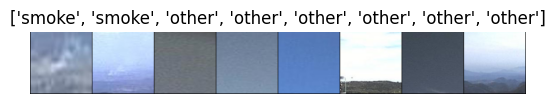

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [ ]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training

    # Set model for evaluation
    vgg.train(False)
    vgg.eval()

    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]


        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)

        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()

        images_so_far += size
        if images_so_far >= num_images:
            break

    vgg.train(mode=was_training) # Revert model back to original training state

In [ ]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0

    test_batches = len(dataloaders[TEST])

    print("Evaluating model")
    print('-' * 10)

    for i, data in enumerate(dataloaders[TEST]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.data.item()
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()

    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]

    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [ ]:

print(main_model)

MainModel(
  (model_list): ModuleList(
    (0): RawToTile_ResNet(
      (conv): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=

In [ ]:
if use_gpu:
    main_model.cuda() #.cuda() will move everything to the GPU side

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(main_model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
print("Test before training")
eval_model(main_model, criterion)

Test before training
Evaluating model
----------
Test batch 0/165torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])


<ipython-input-73-ea058cfcd8dd>:22: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8,

<ipython-input-72-8ec5502ca051>:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


torch.Size([8, 3, 224, 224])
Ground truth:


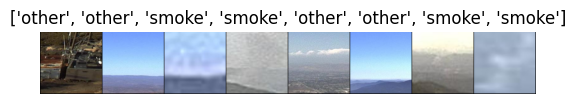

Prediction:


IndexError: ignored

In [ ]:
visualize_model(main_model)

In [ ]:
model = train_model(main_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)
torch.save(model.state_dict(), 'othervssmoke/UCSDmodel(othervssmoke).pt')

Epoch 0/15
----------
Training batch 0/594.0torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])

<ipython-input-70-e91e35471cd3>:71: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


Streaming output truncated to the last 5000 lines.
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
Validation batch 100/339torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224

In [ ]:
eval_model(main_model, criterion)

Evaluating model
----------
Test batch 0/165torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])


<ipython-input-73-ea058cfcd8dd>:22: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224])
torch.Size([8,

<ipython-input-42-8ec5502ca051>:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)


torch.Size([8, 3, 224, 224])
Ground truth:


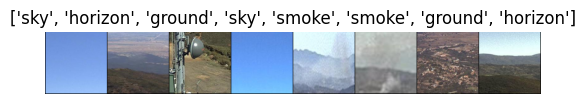

Prediction:


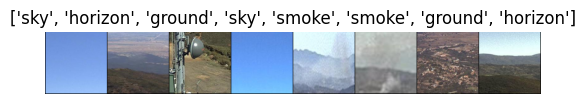

In [ ]:
visualize_model(main_model)